<a href="https://colab.research.google.com/github/skywalker0803r/ruby_research/blob/main/SFOPprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
#!pip install git+https://github.com/jonbarron/robust_loss_pytorch
import robust_loss_pytorch
from torch.utils.data import TensorDataset,DataLoader
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '/gdrive/My Drive/for Ruby'
excel_list=os.listdir(root)
excel_list

['淡水河流域.csv', '淡水河流域final_0429.ipynb', '驗證淡水河流域03_15.ipynb', '2.xlsx']

In [4]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

# some function

In [5]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

def split_data(df,x_col,y_col):
  df = shuffle(df).astype('float32')
  X,Y = df[x_col],df[y_col]
  sp1 = int(len(df)*0.8)
  sp2 = int(len(df)*0.9)
  data = {}
  data['X_train'],data['Y_train'] = X.iloc[:sp1,:],Y.iloc[:sp1,:]
  data['X_vaild'],data['Y_vaild'] = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
  data['X_test'],data['Y_test'] = X.iloc[sp2:,:],Y.iloc[sp2:,:]
  return data

def show_metrics(y_pred,y_real):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
  for i in y_pred.columns:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
  res.loc['AVG'] = res.mean(axis=0)
  return res

def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):
    m.bias.data.fill_(0)

# Part1：預測塔頂塔底組成

# load data

In [6]:
df = pd.read_excel(root+'/2.xlsx') #讀取excel檔
df = df.drop(['Unnamed: 1', 'Unnamed: 2'], axis=1)
df = df.drop(index=1)
col_name = df.iloc[0,:]
df.columns = col_name
df = df.iloc[1:,:] 
df.index = df.iloc[:,0].values
df = df.drop(df.columns[0],axis=1)
print(df.shape)
for i in df.columns:
    df[i] = pd.to_numeric(df[i],errors='coerce')

df['Condenser Duty'] = df['Condenser Duty'].apply(lambda x: x*-1)
df.head()

(1458, 18)


,F.TEMP.MIXED,Feed Flow,F.FLOW.BENZENE,F.FLOW.TOLUENE,Total stage,Reflux ratio,D/F,Feed stage,Stage-2 Efficiencies,Stage-45 Efficiencies,Condenser Temperature,Condenser Duty,D stream BENZENE,D stream TOLUENE,Reboiler Temp,Reboiler Duty,W stream BENZENE,W stream TOLUENE
Case 1,103,50,40,60,46,2.5,0.33,14,0.7,0.7,82.961772,5712.749075,0.991645,0.008355,112.480976,5503.283448,0.146149,0.853851
Case 2,103,50,50,50,46,2.5,0.33,14,0.7,0.7,82.990896,5809.514269,0.989946,0.010054,106.774195,3042.561970,0.284634,0.715366
Case 3,103,50,60,40,46,2.5,0.33,14,0.7,0.7,83.029809,5906.674859,0.987682,0.012318,101.915000,593.089652,0.425427,0.574573
Case 4,103,50,40,60,46,2.5,0.33,19,0.7,0.7,82.845927,5708.665107,0.998416,0.001584,112.594861,5500.205696,0.143621,0.856379
Case 5,103,50,50,50,46,2.5,0.33,19,0.7,0.7,82.851761,5804.515753,0.998074,0.001926,106.894313,3038.549282,0.281451,0.718549


In [7]:
class part(object):
  def __init__(self,df,x_col,y_col,hidden_size=256,lr=0.01,max_epochs=500,robust_loss=False,log_interval=1):
    
    # config
    self.log_interval = log_interval
    self.robust_loss = robust_loss
    self.x_col = x_col
    self.y_col = y_col
    self.hidden_size = hidden_size
    self.lr = lr
    self.max_epochs = max_epochs
    self.ss_x = MinMaxScaler().fit(df[x_col])
    self.ss_y = MinMaxScaler().fit(df[y_col])
    
    # model
    self.net = nn.Sequential(
        nn.Linear(len(self.x_col),self.hidden_size),nn.ReLU(),
        nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU(),
        nn.Linear(self.hidden_size,len(self.y_col)),nn.Sigmoid(),
                  ).apply(init_weights)
    
    # loss_function
    if self.robust_loss == True:
      adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
          num_dims = len(self.y_col),
          float_dtype = np.float32,
          device = 'cpu')
      params = list(self.net.parameters())+list(adaptive.parameters())
      self.loss_fn = lambda y_i,y:torch.mean(adaptive.lossfun((y_i - y)))
    else:
      params = list(self.net.parameters())
      self.loss_fn = lambda y_i,y:torch.mean((y_i-y)**2)
    
    # optimizer
    self.optimizer = torch.optim.Adam(params,lr=self.lr)
    
    # dataset
    self.data = split_data(df,self.x_col,self.y_col)
    
    # data_iter
    self.train_data = TensorDataset(
        torch.FloatTensor(self.ss_x.transform(self.data['X_train'])),
        torch.FloatTensor(self.ss_y.transform(self.data['Y_train'])),
        )
    self.train_iter = DataLoader(self.train_data,batch_size=64)
    
    self.vaild_data = TensorDataset(
        torch.FloatTensor(self.ss_x.transform(self.data['X_vaild'])),
        torch.FloatTensor(self.ss_y.transform(self.data['Y_vaild'])),
        )
    self.vaild_iter = DataLoader(self.vaild_data,batch_size=64)

  def train_step(self):
    self.net.train()
    total_loss = 0
    for t,(x,y) in enumerate(self.train_iter):
      y_hat = self.net(x)
      loss = self.loss_fn(y_hat,y)
      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
      total_loss += loss.item()
    return total_loss/t
  
  def valid_step(self):
    self.net.eval()
    total_loss = 0
    for t,(x,y) in enumerate(self.vaild_iter):
      y_hat = self.net(x)
      loss = self.loss_fn(y_hat,y)
      total_loss += loss.item()
    return total_loss/t

  
  def train(self):
    '''
    train and eval model many epochs
    return best model and plot train_history
    '''   
    history = {
        'train_loss':[],
        'valid_loss':[]
        }
    current_loss = np.inf
    best_model = None
    
    for i in range(self.max_epochs):
      history['train_loss'].append(self.train_step())
      history['valid_loss'].append(self.valid_step())
      
      # pring info
      if i%self.log_interval == 0:
       print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f}".format(
           i,
           history['train_loss'][-1],
           history['valid_loss'][-1]))
      
      # keep the best model
      if history['valid_loss'][-1] <= current_loss:
        best_model = deepcopy(self.net.eval())
        current_loss = history['valid_loss'][-1]
        print('save best model')
    
    # plot history and return best_model
    self.net = deepcopy(best_model.eval())
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['valid_loss'],label='valid_loss')
    plt.legend()
    plt.show()
    return best_model

  def test(self):
    '''
    show model metrics
    '''
    predict = self.get_predict(self.data['X_test'])
    res = show_metrics(predict,self.data['Y_test'])
    return res

  def get_predict(self,x):
    '''
    input :pandas.DataFrame()
    return :pandas.DataFrame()
    '''
    data_index = x.index
    predict = self.net(torch.FloatTensor(self.ss_x.transform(x)))
    predict = self.ss_y.inverse_transform(predict.detach().numpy())
    predict = pd.DataFrame(predict,index=data_index,columns=self.y_col)
    return predict

# PART1

epoch:0 train_loss:0.0570 valid_loss:0.0223
save best model
epoch:1 train_loss:0.0111 valid_loss:0.0180
save best model
epoch:2 train_loss:0.0080 valid_loss:0.0065
save best model
epoch:3 train_loss:0.0046 valid_loss:0.0071
epoch:4 train_loss:0.0049 valid_loss:0.0094
epoch:5 train_loss:0.0059 valid_loss:0.0058
save best model
epoch:6 train_loss:0.0040 valid_loss:0.0045
save best model
epoch:7 train_loss:0.0041 valid_loss:0.0050
epoch:8 train_loss:0.0039 valid_loss:0.0039
save best model
epoch:9 train_loss:0.0033 valid_loss:0.0039
epoch:10 train_loss:0.0031 valid_loss:0.0037
save best model
epoch:11 train_loss:0.0030 valid_loss:0.0035
save best model
epoch:12 train_loss:0.0029 valid_loss:0.0034
save best model
epoch:13 train_loss:0.0028 valid_loss:0.0034
save best model
epoch:14 train_loss:0.0028 valid_loss:0.0034
save best model
epoch:15 train_loss:0.0028 valid_loss:0.0033
save best model
epoch:16 train_loss:0.0027 valid_loss:0.0034
epoch:17 train_loss:0.0027 valid_loss:0.0034
epoch:18

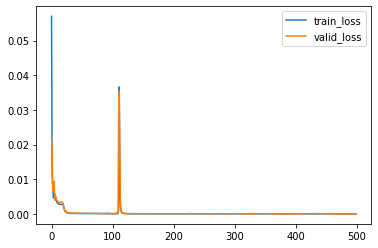

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=4, bias=True)
  (5): Sigmoid()
)

In [8]:
part1 = part(df,df.columns[:10],df.columns[[12,13,16,17]])
part1.train()

In [9]:
res = part1.test()
res

,R2,MSE,MAPE
0,,,
D stream BENZENE,0.999946,2.97125e-07,0.039486
D stream TOLUENE,0.999944,3.07414e-07,89.6697
W stream BENZENE,0.999986,3.19484e-07,9731.85
W stream TOLUENE,0.999987,3.07255e-07,0.0520538
AVG,0.999966,3.0782e-07,2455.4


# PART2

epoch:0 train_loss:0.0279 valid_loss:0.0115
save best model
epoch:1 train_loss:0.0045 valid_loss:0.0042
save best model
epoch:2 train_loss:0.0017 valid_loss:0.0013
save best model
epoch:3 train_loss:0.0008 valid_loss:0.0008
save best model
epoch:4 train_loss:0.0004 valid_loss:0.0006
save best model
epoch:5 train_loss:0.0003 valid_loss:0.0005
save best model
epoch:6 train_loss:0.0002 valid_loss:0.0004
save best model
epoch:7 train_loss:0.0002 valid_loss:0.0003
save best model
epoch:8 train_loss:0.0002 valid_loss:0.0002
save best model
epoch:9 train_loss:0.0001 valid_loss:0.0002
save best model
epoch:10 train_loss:0.0001 valid_loss:0.0002
save best model
epoch:11 train_loss:0.0001 valid_loss:0.0002
save best model
epoch:12 train_loss:0.0001 valid_loss:0.0001
save best model
epoch:13 train_loss:0.0001 valid_loss:0.0001
save best model
epoch:14 train_loss:0.0001 valid_loss:0.0001
save best model
epoch:15 train_loss:0.0001 valid_loss:0.0001
save best model
epoch:16 train_loss:0.0000 valid_l

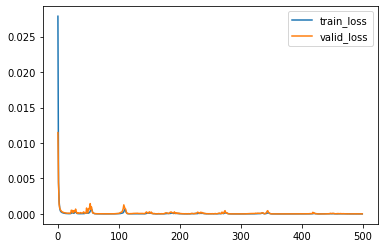

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
  (5): Sigmoid()
)

In [10]:
part2 = part(df,df.columns[:10],df.columns[[11,15]])
part2.train()

In [11]:
part2.test()

,R2,MSE,MAPE
0,,,
Condenser Duty,0.999968,7224.8,0.363492
Reboiler Duty,0.99992,9126.36,1.43084
AVG,0.999944,8175.58,0.897163


# Part 3：預測操作條件(temp)

epoch:0 train_loss:0.0544 valid_loss:0.0269
save best model
epoch:1 train_loss:0.0102 valid_loss:0.0080
save best model
epoch:2 train_loss:0.0051 valid_loss:0.0070
save best model
epoch:3 train_loss:0.0046 valid_loss:0.0082
epoch:4 train_loss:0.0043 valid_loss:0.0062
save best model
epoch:5 train_loss:0.0041 valid_loss:0.0089
epoch:6 train_loss:0.0046 valid_loss:0.0086
epoch:7 train_loss:0.0055 valid_loss:0.0108
epoch:8 train_loss:0.0055 valid_loss:0.0085
epoch:9 train_loss:0.0068 valid_loss:0.0077
epoch:10 train_loss:0.0054 valid_loss:0.0074
epoch:11 train_loss:0.0050 valid_loss:0.0072
epoch:12 train_loss:0.0041 valid_loss:0.0079
epoch:13 train_loss:0.0044 valid_loss:0.0141
epoch:14 train_loss:0.0108 valid_loss:0.0328
epoch:15 train_loss:0.0135 valid_loss:0.0079
epoch:16 train_loss:0.0058 valid_loss:0.0072
epoch:17 train_loss:0.0061 valid_loss:0.0074
epoch:18 train_loss:0.0044 valid_loss:0.0059
save best model
epoch:19 train_loss:0.0035 valid_loss:0.0062
epoch:20 train_loss:0.0033 val

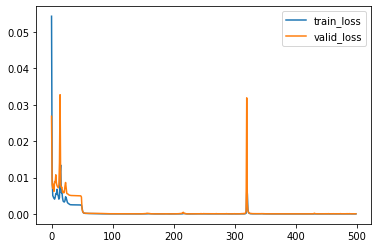

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
  (5): Sigmoid()
)

In [13]:
part3 = part(df,df.columns[:10],df.columns[[10,14]])
part3.train()

In [14]:
part3.test()

,R2,MSE,MAPE
0,,,
Condenser Temperature,0.999945,0.000108861,0.00854232
Reboiler Temp,0.999923,0.00269463,0.0234649
AVG,0.999934,0.00140175,0.0160036
